In [2]:
import os
import os.path as osp
import shutil
import meshio
from typing import List

import logging
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import numpy as np
import scipy.sparse as sp
import tqdm

from mesh_handler import xdmf_to_meshes, meshes_to_xdmf, vtu_to_mesh, mesh_to_vtu, accessing_mesh_data, create_mock_mesh, get_geometric_data

# Demo mock data

In [3]:
# DEMO
print("\n### DEMO  XDMF ARCHIVE ###")
print("2D mesh archive:")
xdmf_path = osp.join(os.getcwd(), "Obstacle.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
meshes[0].points


### DEMO  XDMF ARCHIVE ###
2D mesh archive:
Loaded 121 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\Obstacle.xdmf



array([[0.      , 0.      , 0.      ],
       [4.      , 0.      , 0.      ],
       [4.      , 3.      , 0.      ],
       ...,
       [2.20449 , 0.663779, 0.      ],
       [3.82059 , 2.75713 , 0.      ],
       [0.736707, 0.299932, 0.      ]], shape=(1632, 3), dtype=float32)

In [4]:
accessing_mesh_data(meshes[10])

There are 1632 nodes in this mesh.
First 5 nodes of the mesh: 
[[0.  0.  0. ]
 [4.  0.  0. ]
 [4.  3.  0. ]
 [0.  3.  0. ]
 [0.  2.9 0. ]] 

Types of cells in the mesh: ['triangle']
There are 3122 triangular cells in this mesh.
First 5 triangular cells of the mesh: 
[[ 696 1561  561]
 [ 642  252 1464]
 [ 252  605 1464]
 [ 275  652 1555]
 [1322  664  604]] 

Feature name: Vitesse / Feature shape: (1632, 3)
Feature name: Pression / Feature shape: (1632,)


In [5]:
print("\n3D mesh archive:")
xdmf_path = osp.join(os.getcwd(), "AllFields_Resultats_MESH_1.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
accessing_mesh_data(meshes[10])


3D mesh archive:
Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\AllFields_Resultats_MESH_1.xdmf

There are 11446 nodes in this mesh.
First 5 nodes of the mesh: 
[[-2.205367   4.560882   1.67214  ]
 [-2.2580128  4.7989006  1.8012575]
 [-2.212806   5.078872   1.8893555]
 [-2.0400388  5.2704096  1.920871 ]
 [-1.8397863  5.4581513  1.9444325]] 

Types of cells in the mesh: ['tetra']
There are 55472 tetrahedral cells in this mesh.
First 5 tetrahedral cells of the mesh: 
[[4803 4804 4805 4806]
 [4807    0 2921 2922]
 [4808 1941 4809 4810]
 [4811 4812 4813 4814]
 [4815 3583 4816    3]] 

Feature name: Vitesse / Feature shape: (11446, 3)
Feature name: Pression / Feature shape: (11446,)


In [6]:
mesh = meshes[0]
mesh.cells_dict['tetra']

array([[4803, 4804, 4805, 4806],
       [4807,    0, 2921, 2922],
       [4808, 1941, 4809, 4810],
       ...,
       [6558, 6354, 6587, 6804],
       [6176, 6908, 9039, 6943],
       [6176, 5669, 7795, 6178]], shape=(55472, 4))

In [7]:
def get_neighbors(mesh, cell_idx):
    neighbors = set()
    for i, cell in enumerate(mesh.cells_dict['tetra']):
        if cell_idx in cell:
            # the cell is in this tetrahedron
            for j in cell:
                if j != cell_idx:
                    neighbors.add(j.item())
    return neighbors

mesh = meshes[0]
get_neighbors(mesh, 50)

{49, 51, 801, 3253, 3433, 3434, 6748, 9626, 10349}

In [8]:
print("\n### DEMO  VTU FILE FORMAT ###")
mock_mesh = create_mock_mesh()
vtu_path = osp.join(os.getcwd(), "mock_mesh.vtu")
mesh_to_vtu(mock_mesh, vtu_path)


### DEMO  VTU FILE FORMAT ###
Mock mesh created.
Mesh saved to c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\mock_mesh.vtu


# Real data

In [9]:
xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03/AllFields_Resultats_MESH_1.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
accessing_mesh_data(meshes[10])

Loaded 80 timesteps from AllFields_Resultats_MESH_1.xdmf

There are 11446 nodes in this mesh.
First 5 nodes of the mesh: 
[[-2.205367   4.560882   1.67214  ]
 [-2.2580128  4.7989006  1.8012575]
 [-2.212806   5.078872   1.8893555]
 [-2.0400388  5.2704096  1.920871 ]
 [-1.8397863  5.4581513  1.9444325]] 

Types of cells in the mesh: ['tetra']
There are 55472 tetrahedral cells in this mesh.
First 5 tetrahedral cells of the mesh: 
[[4803 4804 4805 4806]
 [4807    0 2921 2922]
 [4808 1941 4809 4810]
 [4811 4812 4813 4814]
 [4815 3583 4816    3]] 

Feature name: Vitesse / Feature shape: (11446, 3)
Feature name: Pression / Feature shape: (11446,)


# Create train dataset

In [10]:
# we will train the model with times t-2 and t-1 to predict t
# for each point, we can predict vx, vy, vz and p using the previous time steps

def build_data():
    data = {
        'features' : [],
        'target' : []
    }
    list_files = os.listdir(osp.join(os.getcwd(), "4Students_AnXplore03"))
    list_files = [f for f in list_files if f.endswith('.xdmf')]

    for f in tqdm.tqdm(list_files):
        # print("\n\n New file:\n")
        xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03", f)
        meshes = xdmf_to_meshes(xdmf_path)
        mesh = meshes[0]

        edge_index, edge_attr = get_geometric_data(mesh)

        for time_step in range(2, len(meshes)):
            # Create node features (x, y, z, vx, vy, vz, p)
            node_features_1 = np.hstack([
                meshes[time_step-1].points,
                meshes[time_step-1].point_data['Vitesse'],
                meshes[time_step-1].point_data['Pression'].reshape(-1, 1)
            ]) # Shape: (num_nodes, 7)
            node_features_1 = torch.tensor(node_features_1, dtype=torch.float)
            node_features = np.hstack([
                meshes[time_step].points,
                meshes[time_step].point_data['Vitesse'],
                meshes[time_step].point_data['Pression'].reshape(-1, 1)
            ]) # Shape: (num_nodes, 7)
            node_features = torch.tensor(node_features, dtype=torch.float)

            # Create PyTorch Geometric data object
            graph_data_1 = Data(x=node_features_1, edge_index=edge_index, edge_attr=edge_attr)
            graph_data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

            data['features'].append(graph_data_1)
            data['target'].append(graph_data)
    return data

In [11]:
data = build_data()

  0%|          | 0/103 [00:00<?, ?it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_1.xdmf



  1%|          | 1/103 [00:00<01:00,  1.69it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_11.xdmf



  2%|▏         | 2/103 [00:01<01:33,  1.08it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_117.xdmf



  3%|▎         | 3/103 [00:02<01:32,  1.08it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_119-1.xdmf



  4%|▍         | 4/103 [00:03<01:16,  1.29it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_119-2.xdmf



  5%|▍         | 5/103 [00:03<01:08,  1.42it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_120.xdmf



  6%|▌         | 6/103 [00:04<01:12,  1.33it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_121.xdmf



  7%|▋         | 7/103 [00:05<01:07,  1.43it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_128.xdmf



  8%|▊         | 8/103 [00:06<01:10,  1.34it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_129.xdmf



  9%|▊         | 9/103 [00:06<01:06,  1.42it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_134.xdmf



 10%|▉         | 10/103 [00:07<01:02,  1.50it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_135.xdmf



 11%|█         | 11/103 [00:07<00:59,  1.54it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_136.xdmf



 12%|█▏        | 12/103 [00:08<01:01,  1.48it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_137.xdmf



 13%|█▎        | 13/103 [00:09<01:01,  1.45it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_138.xdmf



 14%|█▎        | 14/103 [00:09<00:59,  1.48it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_139.xdmf



 15%|█▍        | 15/103 [00:10<00:58,  1.51it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_140.xdmf



 16%|█▌        | 16/103 [00:11<01:02,  1.40it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_142.xdmf



 17%|█▋        | 17/103 [00:12<00:58,  1.47it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_144-2.xdmf



 17%|█▋        | 18/103 [00:12<00:58,  1.44it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_148.xdmf



 18%|█▊        | 19/103 [00:13<00:57,  1.47it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_151.xdmf



 19%|█▉        | 20/103 [00:14<01:00,  1.38it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_152.xdmf



 20%|██        | 21/103 [00:14<00:58,  1.41it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_153.xdmf



 21%|██▏       | 22/103 [00:15<01:00,  1.35it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_155.xdmf



 22%|██▏       | 23/103 [00:16<00:58,  1.37it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_157.xdmf



 23%|██▎       | 24/103 [00:17<00:54,  1.46it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_158.xdmf



 24%|██▍       | 25/103 [00:17<00:51,  1.51it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_159.xdmf



 25%|██▌       | 26/103 [00:18<00:50,  1.52it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_161.xdmf



 26%|██▌       | 27/103 [00:18<00:49,  1.53it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_162.xdmf



 27%|██▋       | 28/103 [00:19<00:47,  1.57it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_163-1.xdmf



 28%|██▊       | 29/103 [00:20<00:49,  1.51it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_163-2.xdmf



 29%|██▉       | 30/103 [00:21<00:53,  1.36it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_164.xdmf



 30%|███       | 31/103 [00:21<00:55,  1.30it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_165.xdmf



 31%|███       | 32/103 [00:23<01:00,  1.17it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_166.xdmf



 32%|███▏      | 33/103 [00:23<00:58,  1.20it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_168-1.xdmf



 33%|███▎      | 34/103 [00:24<01:00,  1.13it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_168-2.xdmf



 34%|███▍      | 35/103 [00:25<00:58,  1.16it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_170.xdmf



 35%|███▍      | 36/103 [00:26<00:57,  1.16it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_171.xdmf



 36%|███▌      | 37/103 [00:27<01:00,  1.10it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_172.xdmf



 37%|███▋      | 38/103 [00:29<01:17,  1.19s/it]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_173.xdmf



 38%|███▊      | 39/103 [00:30<01:13,  1.14s/it]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_174.xdmf



 39%|███▉      | 40/103 [00:31<01:06,  1.06s/it]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_175.xdmf



 40%|███▉      | 41/103 [00:32<01:02,  1.01s/it]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_177.xdmf



 41%|████      | 42/103 [00:33<01:09,  1.14s/it]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_178.xdmf



 42%|████▏     | 43/103 [00:34<00:58,  1.03it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_180.xdmf



 43%|████▎     | 44/103 [00:34<00:49,  1.19it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_181.xdmf



 44%|████▎     | 45/103 [00:35<00:44,  1.30it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_182-1.xdmf



 45%|████▍     | 46/103 [00:35<00:40,  1.40it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_182-2.xdmf



 46%|████▌     | 47/103 [00:36<00:37,  1.48it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_182-3.xdmf



 47%|████▋     | 48/103 [00:37<00:36,  1.53it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_183.xdmf



 48%|████▊     | 49/103 [00:37<00:35,  1.53it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_185.xdmf



 49%|████▊     | 50/103 [00:38<00:34,  1.53it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_186-1.xdmf



 50%|████▉     | 51/103 [00:39<00:37,  1.40it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_186-2.xdmf



 50%|█████     | 52/103 [00:39<00:35,  1.46it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_187.xdmf



 51%|█████▏    | 53/103 [00:40<00:35,  1.42it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_188.xdmf



 52%|█████▏    | 54/103 [00:41<00:33,  1.45it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_189.xdmf



 53%|█████▎    | 55/103 [00:41<00:31,  1.53it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_19.xdmf



 54%|█████▍    | 56/103 [00:42<00:30,  1.56it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_191.xdmf



 55%|█████▌    | 57/103 [00:43<00:31,  1.44it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_192.xdmf



 56%|█████▋    | 58/103 [00:43<00:30,  1.47it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_193-1.xdmf



 57%|█████▋    | 59/103 [00:45<00:35,  1.24it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_193-2.xdmf



 58%|█████▊    | 60/103 [00:45<00:36,  1.18it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_194.xdmf



 59%|█████▉    | 61/103 [00:46<00:35,  1.17it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_195.xdmf



 60%|██████    | 62/103 [00:47<00:34,  1.18it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_196-1.xdmf



 61%|██████    | 63/103 [00:48<00:33,  1.18it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_196-2.xdmf



 62%|██████▏   | 64/103 [00:49<00:34,  1.14it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_197.xdmf



 63%|██████▎   | 65/103 [00:50<00:31,  1.19it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_198-1.xdmf



 64%|██████▍   | 66/103 [00:51<00:31,  1.19it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_198-2.xdmf



 65%|██████▌   | 67/103 [00:51<00:30,  1.19it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_199.xdmf



 66%|██████▌   | 68/103 [00:52<00:29,  1.19it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_2.xdmf



 67%|██████▋   | 69/103 [00:53<00:28,  1.20it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_200.xdmf



 68%|██████▊   | 70/103 [00:54<00:30,  1.09it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_202.xdmf



 69%|██████▉   | 71/103 [00:55<00:30,  1.05it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_203.xdmf



 70%|██████▉   | 72/103 [00:56<00:28,  1.08it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_204.xdmf



 71%|███████   | 73/103 [00:57<00:31,  1.05s/it]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_205.xdmf



 72%|███████▏  | 74/103 [00:58<00:28,  1.02it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_206.xdmf



 73%|███████▎  | 75/103 [00:59<00:24,  1.16it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_207.xdmf



 74%|███████▍  | 76/103 [00:59<00:21,  1.25it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_208.xdmf



 75%|███████▍  | 77/103 [01:00<00:21,  1.21it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_209.xdmf



 76%|███████▌  | 78/103 [01:01<00:19,  1.26it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_210.xdmf



 77%|███████▋  | 79/103 [01:02<00:20,  1.18it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_211.xdmf



 78%|███████▊  | 80/103 [01:03<00:19,  1.16it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_212.xdmf



 79%|███████▊  | 81/103 [01:04<00:18,  1.21it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_213.xdmf



 80%|███████▉  | 82/103 [01:05<00:17,  1.19it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_214.xdmf



 81%|████████  | 83/103 [01:06<00:17,  1.14it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_215.xdmf



 82%|████████▏ | 84/103 [01:06<00:16,  1.16it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_217.xdmf



 83%|████████▎ | 85/103 [01:07<00:15,  1.14it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_219.xdmf



 83%|████████▎ | 86/103 [01:08<00:15,  1.10it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_23.xdmf



 84%|████████▍ | 87/103 [01:09<00:14,  1.10it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_25.xdmf



 85%|████████▌ | 88/103 [01:10<00:13,  1.09it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_26.xdmf



 86%|████████▋ | 89/103 [01:13<00:22,  1.63s/it]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_28.xdmf



 87%|████████▋ | 90/103 [01:16<00:24,  1.88s/it]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_3.xdmf



 88%|████████▊ | 91/103 [01:17<00:20,  1.75s/it]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_31.xdmf



 89%|████████▉ | 92/103 [01:18<00:16,  1.51s/it]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_34.xdmf



 90%|█████████ | 93/103 [01:19<00:12,  1.25s/it]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_40.xdmf



 91%|█████████▏| 94/103 [01:19<00:09,  1.06s/it]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_42-1.xdmf



 92%|█████████▏| 95/103 [01:20<00:07,  1.04it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_42-2.xdmf



 93%|█████████▎| 96/103 [01:21<00:06,  1.10it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_42-3.xdmf



 94%|█████████▍| 97/103 [01:22<00:05,  1.20it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_44.xdmf



 95%|█████████▌| 98/103 [01:22<00:03,  1.28it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_54-1.xdmf



 96%|█████████▌| 99/103 [01:23<00:02,  1.35it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_54-2.xdmf



 97%|█████████▋| 100/103 [01:24<00:02,  1.39it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_55.xdmf



 98%|█████████▊| 101/103 [01:25<00:01,  1.13it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_6.xdmf



 99%|█████████▉| 102/103 [01:26<00:00,  1.05it/s]

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_9-1.xdmf



100%|██████████| 103/103 [01:27<00:00,  1.18it/s]


In [12]:
data['features'][0]

Data(x=[11446, 7], edge_index=[2, 110854], edge_attr=[110854, 3])

In [13]:
data['target'][0]

Data(x=[11446, 7], edge_index=[2, 110854], edge_attr=[110854, 3])

In [14]:
data.keys()

dict_keys(['features', 'target'])

In [15]:
# get length of the data
len(data['features'])

8034

# Message passing model, t to t+1

In [16]:
from models.GNNPredictor import GNNPredictor

In [17]:
dataset = [
    (data['features'][i], data['target'][i])
    for i in range(100) # use only the first 100 time steps for computational reasons
    # for i in range(len(data['features']))
]

# Create a DataLoader with batch support
batch_size = 16
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate Model and Optimizer
model = GNNPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

c:\miniconda\envs\idsc_challenge_jan\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [21]:
# Train the model
model.train_model(loader, optimizer, epochs=100)

# Save model
torch.save(model.state_dict(), "gnn_model.pth")

print("Training complete!")

  0%|          | 0/100 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [18]:
# load model from gnn_model.pth file
model = GNNPredictor()
model.load_state_dict(torch.load("gnn_model.pth"))
xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03", "AllFields_Resultats_MESH_219.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
total_error, list_errors = model.test_model(meshes)

C:\Users\alexi\AppData\Local\Temp\ipykernel_49084\3379272557.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("gnn_model.pth"))


Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_219.xdmf

Total error: 13395779721678692372447232.0000


In [19]:
list_errors

[4.4992594718933105,
 24.79535675048828,
 62.088966369628906,
 132.77098083496094,
 213.34913635253906,
 289.0500183105469,
 314.8927001953125,
 283.2749328613281,
 226.212646484375,
 181.05934143066406,
 143.78428649902344,
 131.27053833007812,
 159.33602905273438,
 269.5675964355469,
 607.7508544921875,
 1554.509033203125,
 3927.156982421875,
 8621.470703125,
 14865.251953125,
 23022.64453125,
 37535.98828125,
 47164.57421875,
 57248.93359375,
 80889.375,
 145367.453125,
 343176.0,
 895540.625,
 2347191.75,
 6168359.0,
 15862154.0,
 39573356.0,
 97524416.0,
 240402016.0,
 591133888.0,
 1419810432.0,
 3365115392.0,
 8026119680.0,
 19652182016.0,
 48624332800.0,
 116517412864.0,
 279168090112.0,
 683184553984.0,
 1750261563392.0,
 4520895053824.0,
 11050859626496.0,
 27068549038080.0,
 68152406835200.0,
 181180712353792.0,
 480591707373568.0,
 1185049256919040.0,
 2943756626034688.0,
 7594721950040064.0,
 2.075090685735731e+16,
 5.576251818167501e+16,
 1.3820333739160371e+17,
 3.476529

In [20]:
errors = list_errors[:25]
errors

[4.4992594718933105,
 24.79535675048828,
 62.088966369628906,
 132.77098083496094,
 213.34913635253906,
 289.0500183105469,
 314.8927001953125,
 283.2749328613281,
 226.212646484375,
 181.05934143066406,
 143.78428649902344,
 131.27053833007812,
 159.33602905273438,
 269.5675964355469,
 607.7508544921875,
 1554.509033203125,
 3927.156982421875,
 8621.470703125,
 14865.251953125,
 23022.64453125,
 37535.98828125,
 47164.57421875,
 57248.93359375,
 80889.375,
 145367.453125]

In [21]:
# debug code for some error I honestly didn't understand that made the kernel crash
# import os
# import matplotlib
# import shutil

# cache_dir = matplotlib.get_cachedir()
# shutil.rmtree(cache_dir)

25


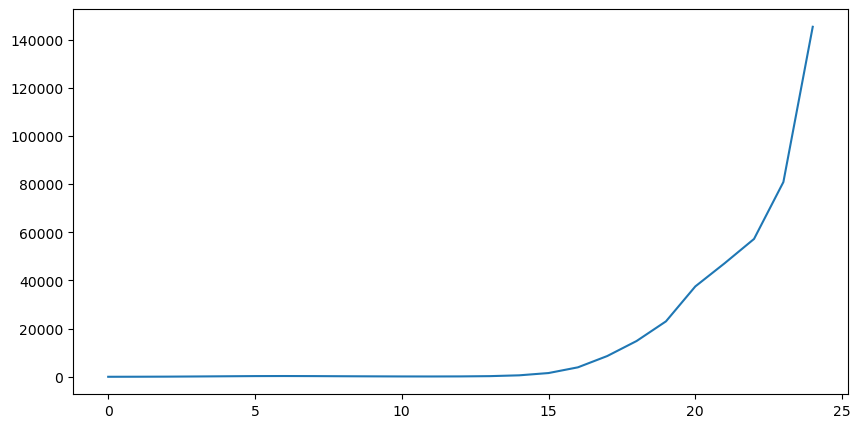

In [22]:
print(len(errors))

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.figure(figsize=(10, 5))

plt.plot(np.array(errors, dtype=np.float32))
# plt.xlabel("Time step")
# plt.ylabel("MSE")
# plt.title("MSE per time step")
plt.savefig("MSE_per_time_step.png")
plt.show()

# Message passing model with RNN (RecurrentGNN)

In [26]:
# from models.RecurrentGNN import RecurrentGNN

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GatedGraphConv
import numpy as np
import tqdm

from mesh_handler import get_geometric_data

class RecurrentGNN(torch.nn.Module):
    def __init__(self, input_dim=7, hidden_dim=64, output_dim=7):
        super(RecurrentGNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.gnn_conv = GCNConv(input_dim, hidden_dim)
        self.rnn = torch.nn.GRU(hidden_dim, hidden_dim, batch_first=True)  # GRU for temporal info
        self.fc = torch.nn.Linear(hidden_dim, output_dim)  # Output: vx, vy, vz, p

        # self.gnn = GatedGraphConv(out_channels=hidden_dim, num_layers=3)
        # self.rnn = torch.nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        # self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, hidden_state):
        if hidden_state is None:
            hidden_state = torch.zeros(1, 1, self.hidden_dim, device=x.device)

        # print(f"Initial x shape: {x.shape}, hidden_state shape: {hidden_state.shape}")
        x = self.gnn_conv(x, edge_index)
        x, hidden_state = self.rnn(x.unsqueeze(0), hidden_state)  # RNN step
        x = self.fc(x.squeeze(0))
        # print(f"Final x shape: {x.shape}, hidden_state shape: {hidden_state.shape}")
        return x, hidden_state
    
    def train_model(self, loader, optimizer, epochs=100):
        self.train()
        for epoch in tqdm.tqdm(range(epochs)):
            total_loss = 0
            hidden_state = None  # Reset hidden state at the start of each epoch

            for data_t_minus_1, data_t in loader:
                
            optimizer.zero_grad()
                x_pred, hidden_state = self.forward(data_t_minus_1.x, data_t_minus_1.edge_index, hidden_state)
                loss = F.mse_loss(x_pred, data_t.x)
                loss.backward()
                total_loss += loss.item()
                optimizer.step() 
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch} | Loss: {total_loss:.4f}")
    
    def test_model(self, meshes):
        # test the model on a sequence of meshes
        # start from time t=2 and predict each step until the end
        # use the previous time steps to predict the next one
        # the final error is 1/T * sum_t sqrt(1/N * sum_n (x_t - x_t_pred)^2)

        # create the ground truth data
        edge_index, edge_attr = get_geometric_data(meshes[0])
        x_list_truth = []
        for time_step in range(len(meshes)):
            node_features = np.hstack([
                meshes[time_step].points,
                meshes[time_step].point_data['Vitesse'],
                meshes[time_step].point_data['Pression'].reshape(-1, 1)
            ]) # Shape: (num_nodes, 7)
            node_features = torch.tensor(node_features, dtype=torch.float)
            x_list_truth.append(node_features)

        graph_data = Data(x=x_list_truth[1], edge_index=edge_index, edge_attr=edge_attr)

        # predict each time step
        total_error = 0
        list_errors = []
        hidden_state = None
        for i in range(2, len(meshes)):
            x, hidden_state = self.forward(graph_data.x, graph_data.edge_index, hidden_state=hidden_state)
            error = F.mse_loss(x, x_list_truth[i])/len(meshes[0].points)
            list_errors.append(error.item())
            total_error += error.item()
            graph_data = Data(x=x, edge_index=graph_data.edge_index, edge_attr=graph_data.edge_attr)
        total_error /= len(meshes)
        print(f"Total error: {total_error:.4f}")
        return total_error, list_errors

In [27]:
dataset = [
    (data['features'][i], data['target'][i])
    for i in range(20) # use only the first 100 time steps for computational reasons
    # for i in range(len(data['features']))
]

# Create a DataLoader with batch support
batch_size = 16
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate Model and Optimizer
model = RecurrentGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [29]:
# Train the model
model.train_model(loader, optimizer, epochs=10)

# Save model
torch.save(model.state_dict(), "recurrent_gnn_model.pth")

print("Training complete!")

  0%|          | 0/10 [01:29<?, ?it/s]


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [29]:
# load model from gnn_model.pth file
model = RecurrentGNN()
model.load_state_dict(torch.load("recurrent_gnn_model.pth"))
xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03", "AllFields_Resultats_MESH_219.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
total_error, list_errors = model.test_model(meshes)

C:\Users\alexi\AppData\Local\Temp\ipykernel_53968\3030062572.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("recurrent_gnn_model.pth"))

RuntimeError: Error(s) in loading state_dict for RecurrentGNN:
	Missing key(s) in state_dict: "gnn.bias", "gnn.lin.weight". 
	Unexpected key(s) in state_dict: "gnn.weight", "gnn.rnn.weight_ih", "gnn.rnn.weight_hh", "gnn.rnn.bias_ih", "gnn.rnn.bias_hh". 

In [ ]:
list_errors

[4.4992594718933105,
 24.79535675048828,
 62.088966369628906,
 132.77098083496094,
 213.34913635253906,
 289.0500183105469,
 314.8927001953125,
 283.2749328613281,
 226.212646484375,
 181.05934143066406,
 143.78428649902344,
 131.27053833007812,
 159.33602905273438,
 269.5675964355469,
 607.7508544921875,
 1554.509033203125,
 3927.156982421875,
 8621.470703125,
 14865.251953125,
 23022.64453125,
 37535.98828125,
 47164.57421875,
 57248.93359375,
 80889.375,
 145367.453125,
 343176.0,
 895540.625,
 2347191.75,
 6168359.0,
 15862154.0,
 39573356.0,
 97524416.0,
 240402016.0,
 591133888.0,
 1419810432.0,
 3365115392.0,
 8026119680.0,
 19652182016.0,
 48624332800.0,
 116517412864.0,
 279168090112.0,
 683184553984.0,
 1750261563392.0,
 4520895053824.0,
 11050859626496.0,
 27068549038080.0,
 68152406835200.0,
 181180712353792.0,
 480591707373568.0,
 1185049256919040.0,
 2943756626034688.0,
 7594721950040064.0,
 2.075090685735731e+16,
 5.576251818167501e+16,
 1.3820333739160371e+17,
 3.476529

In [ ]:
errors = list_errors[:25]
errors

[4.4992594718933105,
 24.79535675048828,
 62.088966369628906,
 132.77098083496094,
 213.34913635253906,
 289.0500183105469,
 314.8927001953125,
 283.2749328613281,
 226.212646484375,
 181.05934143066406,
 143.78428649902344,
 131.27053833007812,
 159.33602905273438,
 269.5675964355469,
 607.7508544921875,
 1554.509033203125,
 3927.156982421875,
 8621.470703125,
 14865.251953125,
 23022.64453125,
 37535.98828125,
 47164.57421875,
 57248.93359375,
 80889.375,
 145367.453125]

In [ ]:
# debug code for some error I honestly didn't understand that made the kernel crash
# import os
# import matplotlib
# import shutil

# cache_dir = matplotlib.get_cachedir()
# shutil.rmtree(cache_dir)

25


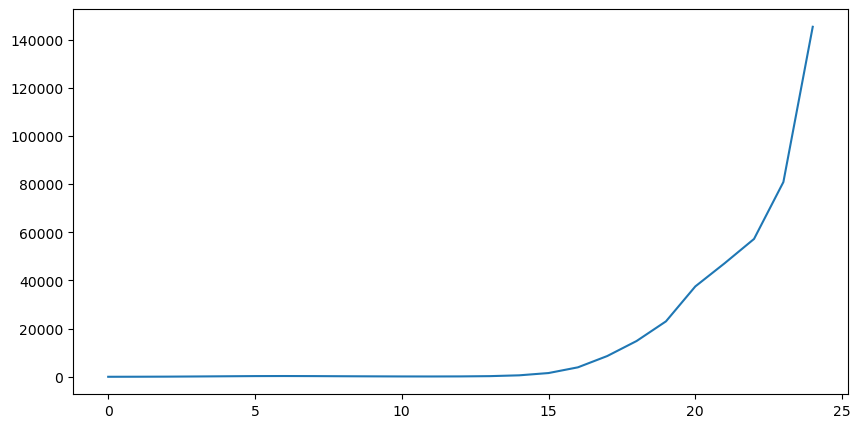

In [ ]:
print(len(errors))

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.figure(figsize=(10, 5))

plt.plot(np.array(errors, dtype=np.float32))
# plt.xlabel("Time step")
# plt.ylabel("MSE")
# plt.title("MSE per time step")
plt.savefig("MSE_per_time_step.png")
plt.show()